In [1]:
from model import *
from dilateModel import *
from data import *
from PIL import Image

import matplotlib.pyplot as plt
import cv2

from keras.models import Sequential
from keras.layers import Dense, Activation

%matplotlib notebook

Using TensorFlow backend.
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packag

### Load base model 

In [2]:
model = unet()
model.load_weights("Humphries_Bragg_Weights.hdf5")


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/dspuser/unet/model.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


In [3]:
def predImgGen(imgPath, target_size=(256,256)):
    img = io.imread(imgPath,as_gray = True)
    img = img / 255
    img = trans.resize(img,target_size)
    img = np.reshape(img,img.shape+(1,))
    img = np.reshape(img,(1,)+img.shape)
    return img

### Make first predictions for masks

In [4]:
testImg = predImgGen('/data/spacenet/bldg/AllTest/PAN-PNG/PAN_AOI_2_Vegas_img1016.png')
pred = model.predict(testImg)

### Here I define a function making my custom kernel initializer (custom filter)

In [5]:


def kernel_init(shape, dtype = None):
    kernel = np.zeros(shape)
    kernel[:,:,0,0] = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
    return kernel

### Run second CNN model with one edge detection layer (using new initializer)

In [6]:
model1 = Sequential()
model1.add(Conv2D(1, [3,3], kernel_initializer=kernel_init, input_shape=(256,256,1), padding="same"))
model1.build()

In [7]:
pred1 = model1.predict(pred)

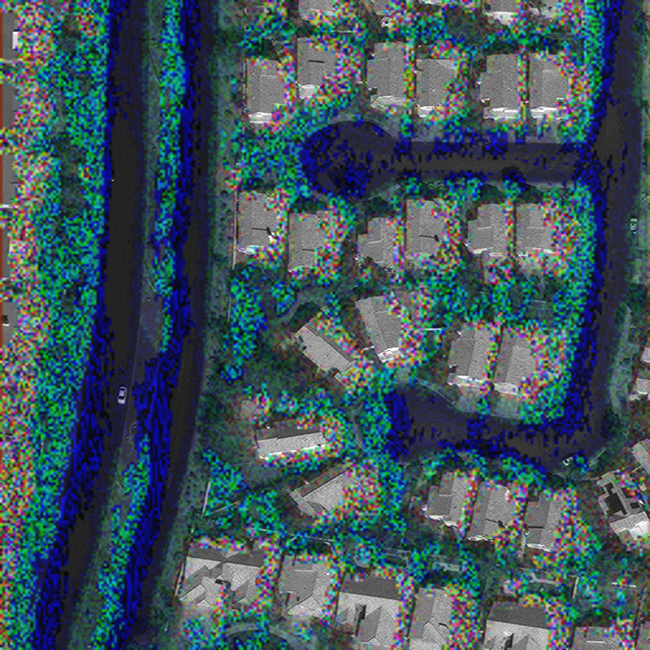

In [8]:
predRe = pred1.reshape(256,256)
maskArrThresh = np.zeros((predRe.shape[0], predRe.shape[1], 4)) 
maskArrThresh[:,:, 0] = 50
maskArrThresh[:,:, 1] = 255
maskArrThresh[:,:, 2] = 0
for row in range(0, predRe.shape[0]):
    for col in range(0, predRe.shape[1]):
        maskArrThresh[row, col, 3] = 255 - int(predRe[row, col] * 255)
maskArrThresh = maskArrThresh.astype("uint8")
maskImg = Image.fromarray(predRe, 'RGBA')

PANImg = Image.open('/data/spacenet/bldg/AllTest/PAN-PNG/PAN_AOI_2_Vegas_img1016.png')
PANImgT = PANImg.convert('RGBA')
        
PANDim = (PANImgT.width, PANImgT.height)
maskImgRe = maskImg.resize(PANDim) 
        
comp = Image.alpha_composite(PANImgT, maskImgRe)
comp

In [11]:
comp.save('comp1.png')

In [ ]:

# maskOTSUImg = Image.open('/home/dspuser/unet/34stMicroMaskThresh.png').convert('RGB')



-1

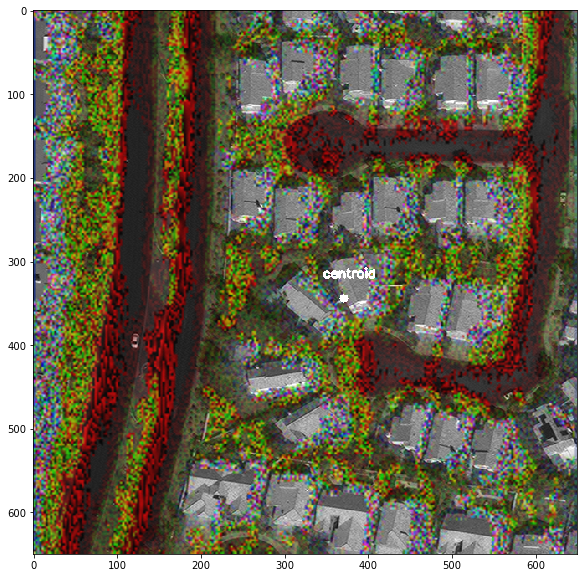

In [19]:
# convert image to grayscale image
image = cv2.imread('comp1.png')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# convert the grayscale image to binary image
ret,thresh = cv2.threshold(gray_image,127,255,0)

# calculate moments of binary image
M = cv2.moments(thresh)

# calculate x,y coordinate of center
cX = int(M["m10"] / M["m00"])

cY = int(M["m01"] / M["m00"])


# put text and highlight the center

cv2.circle(image, (cX, cY), 5, (255, 255, 255), -1)

cv2.putText(image, "centroid", (cX - 25, cY - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

plt.figure(figsize = (10,10))
plt.imshow(image)
cv2.waitKey(0)